In [1]:
from __future__ import annotations

import itertools
from pathlib import Path
import random
import string
from scipy.signal import welch
import numpy as np
import mne
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from fooof import FOOOF

from spk2extract.logs import logger
from spk2extract.extraction.oscillations import LfpSignal, get_data

from scipy.signal import coherence
# Setup functions, classes and styles
logger.setLevel("INFO")
sns.set_style("darkgrid")

data_path = Path().home() / "data" / "extracted" / "dk1"
file = list(data_path.glob("*dk1*.h5"))[0]
df_s, df_t, events, event_times = get_data(file)
unique_events = np.unique(events)
key = {
    "0": "dug incorrectly",
    "1": "dug correctly",
    "x": "crossed over (no context)",
    "b": "crossed over into the black room",
    "w": "crossed over into the white room",
}
fs = 2000
lfp = LfpSignal(df_s, df_t, event_arr=events, ev_times_arr=event_times, fs=2000, filename=file,
                exclude=["LFP1_AON", "LFP2_AON"])


# Data Exploration
1) Show the first 4 channels

In [ ]:
plt.rcParams.update({'font.size': 20, 'font.weight': 'bold', 'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})
# Plot each channel ------------------------
num_channels = len(lfp.spikes.columns)
fig, axes = plt.subplots(num_channels, 1, figsize=(50, 40), sharex=True)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (uV)")
first_4_seconds = int(1 * fs)
ticks = [0, int(1.0 * fs), int(2.0 * fs), int(3.0 * fs), int(4.0 * fs)]

for i, channel in enumerate(lfp.spikes.columns):
    ax = axes[i]
    ax.plot(lfp.spikes[channel][:first_4_seconds])
    t = lfp.spikes[channel][:first_4_seconds]
    ax.set_ylabel("Voltage (uV)")
    ax.set_title(channel)
    ax.grid(True)

# Show morlet wavelet transform for a single channel, each event type

Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mo

/tmp/ipykernel_47609/443896571.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,6))


Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)
Applying baseline correction (mode: zscore)


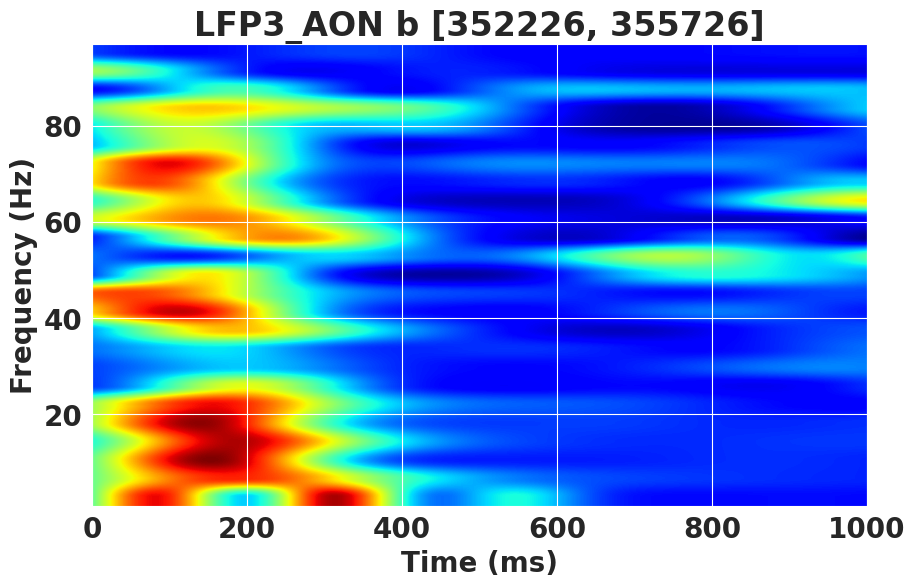

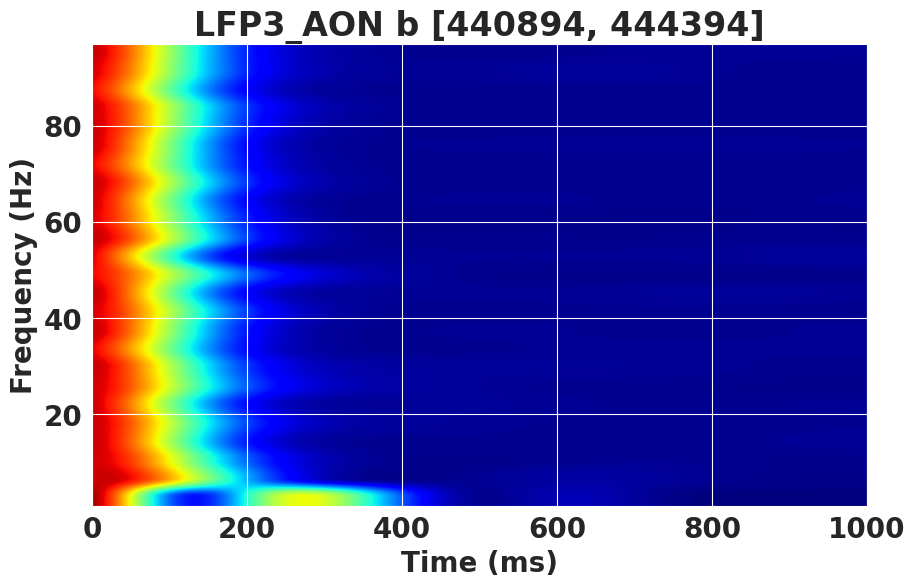

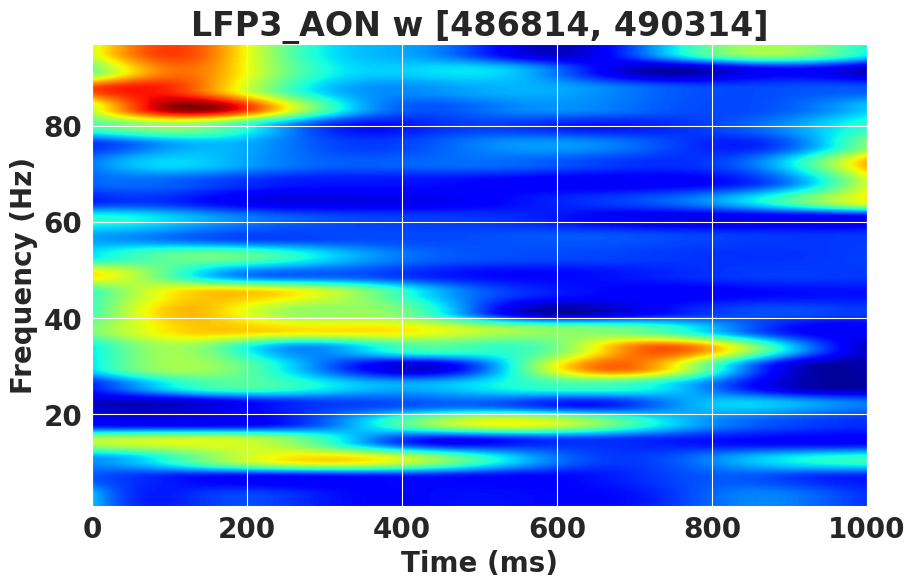

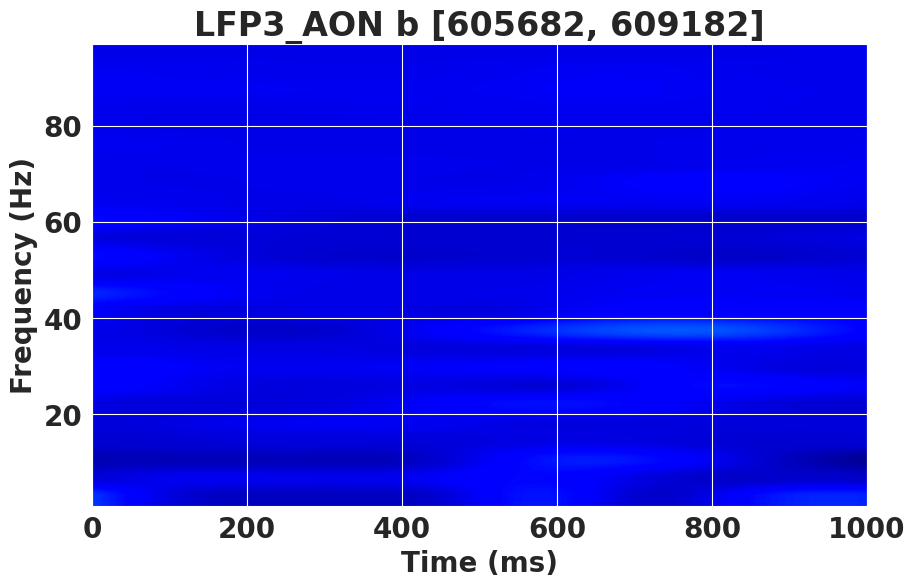

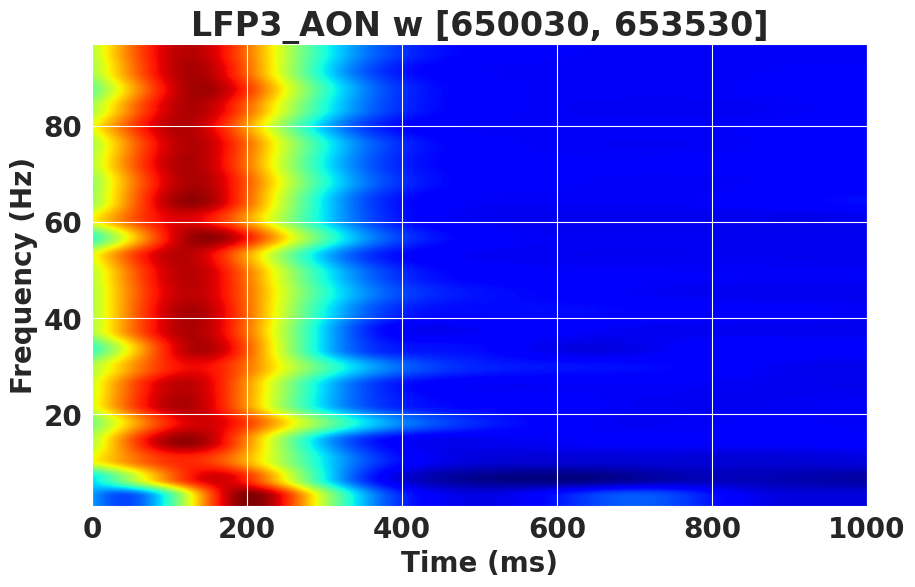

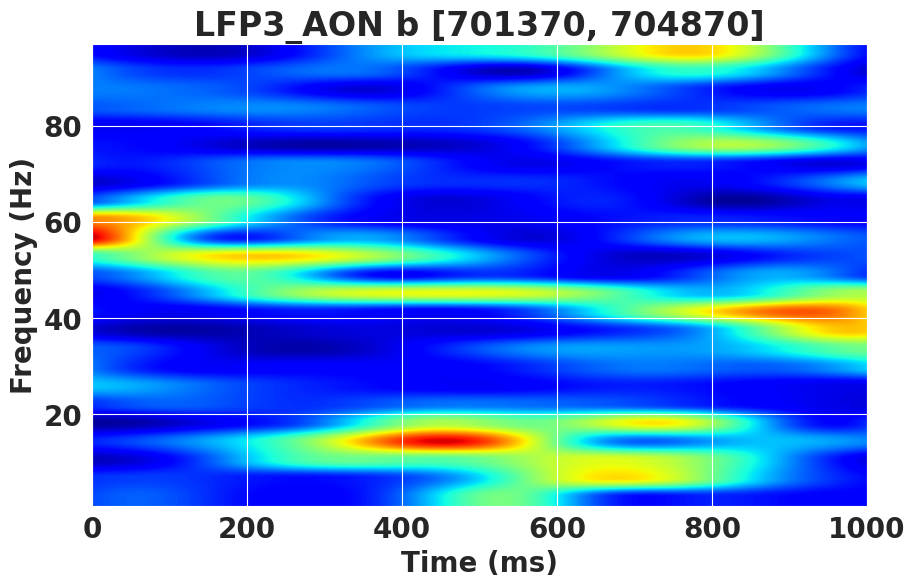

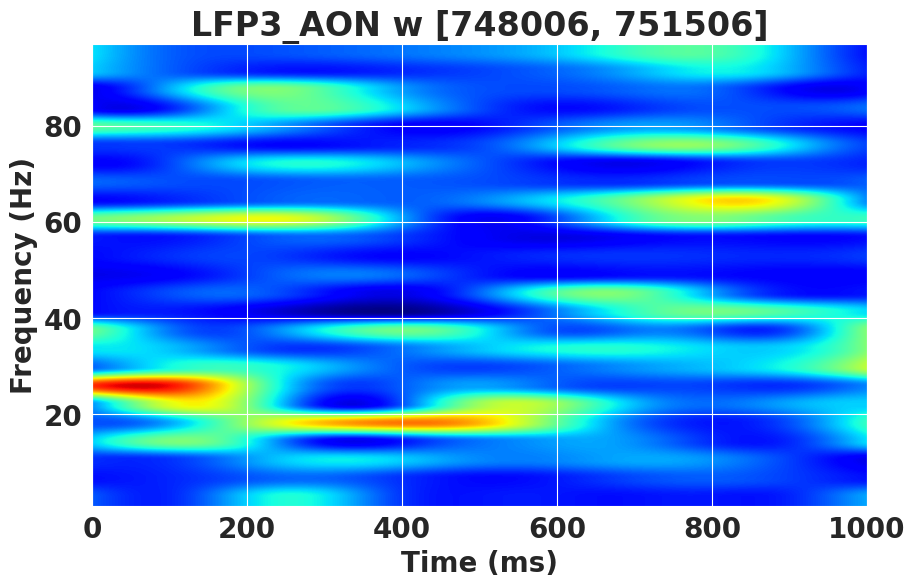

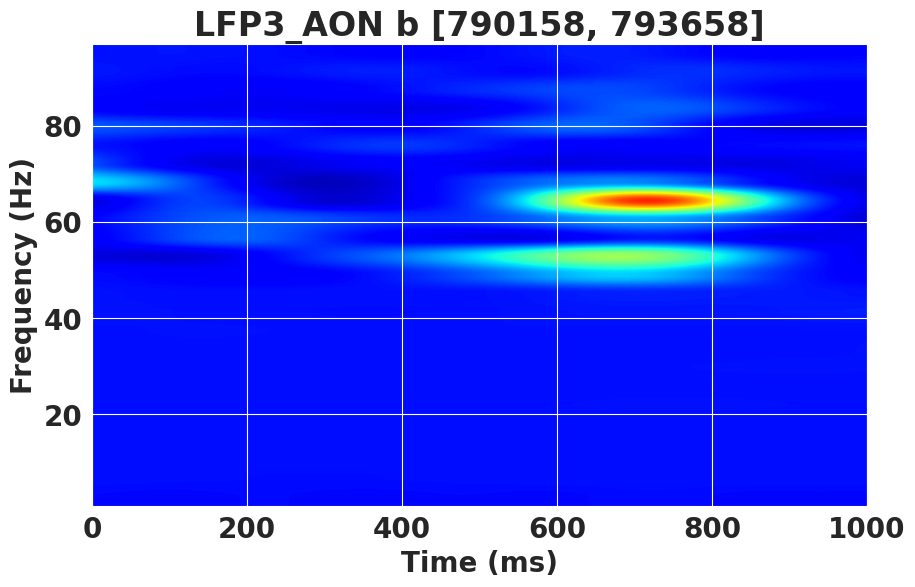

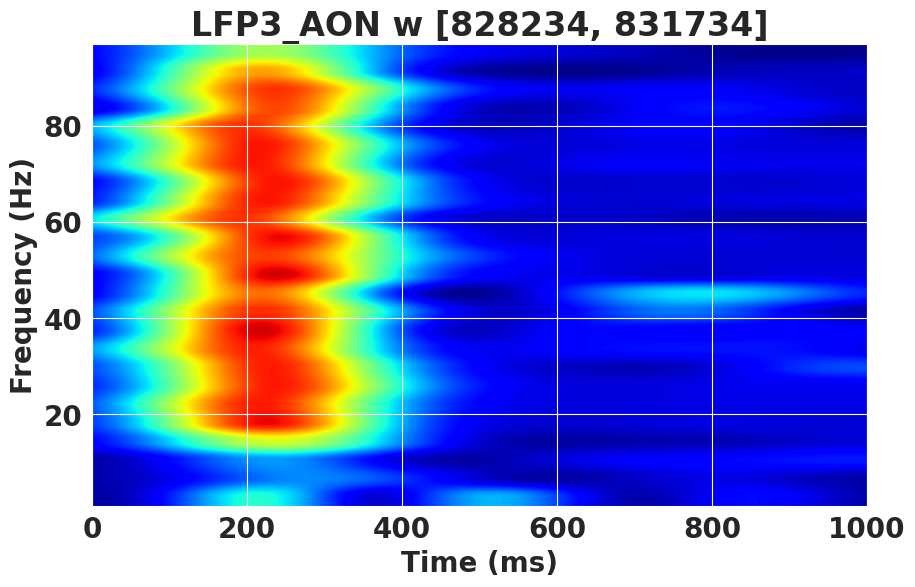

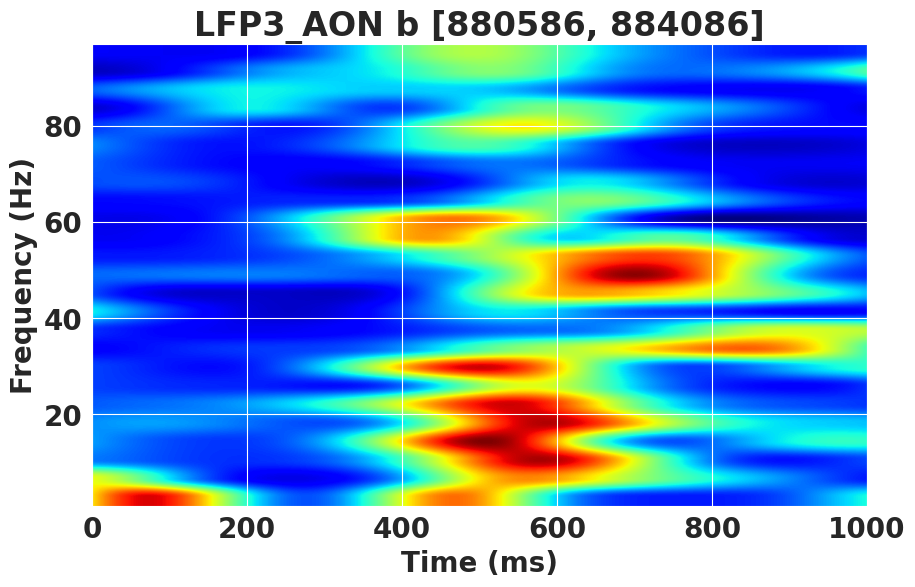

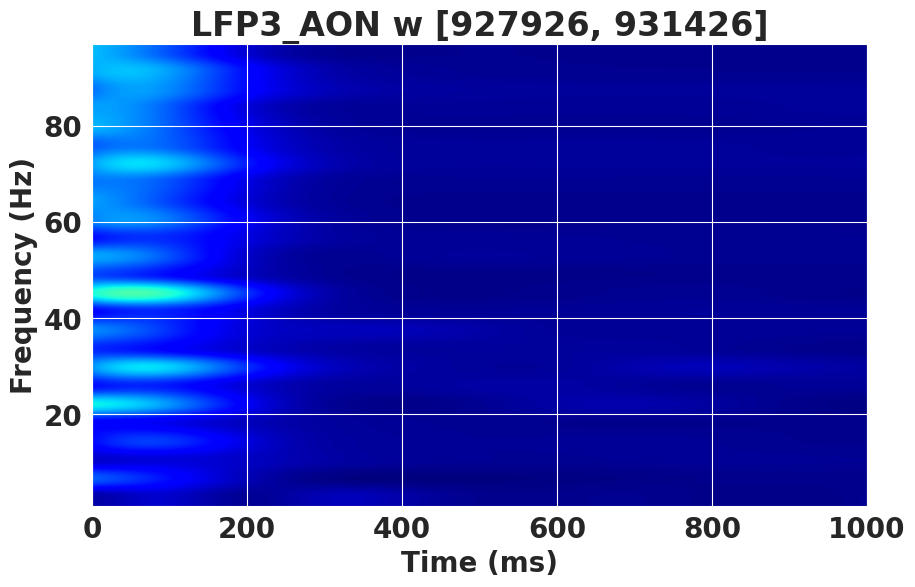

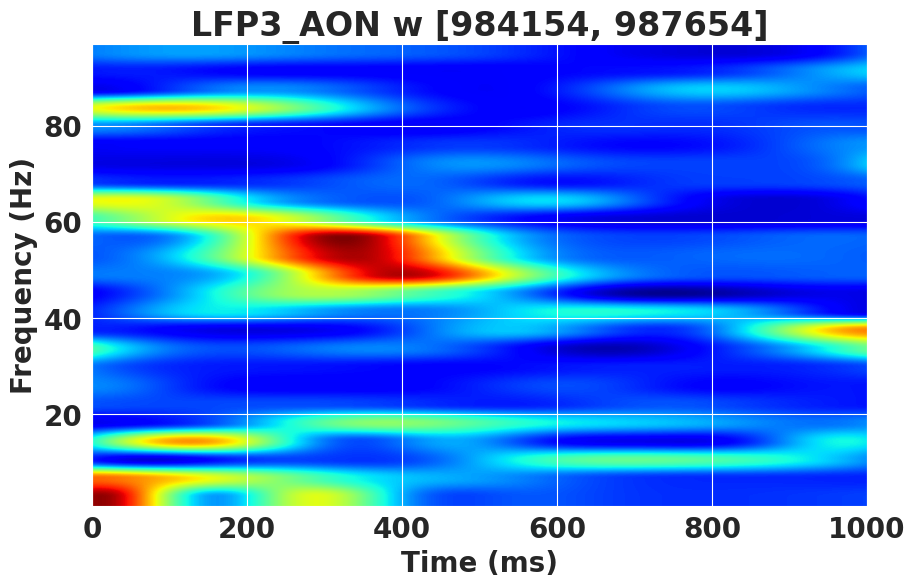

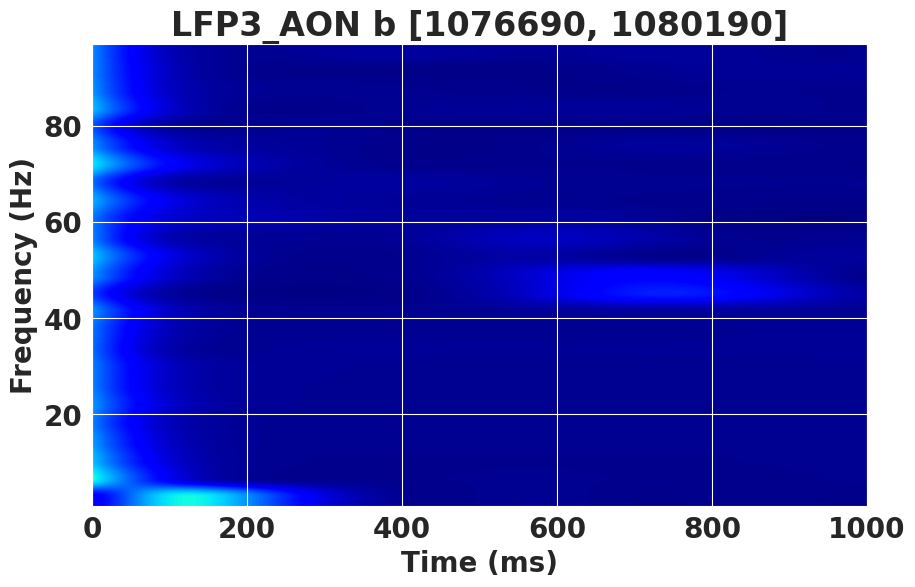

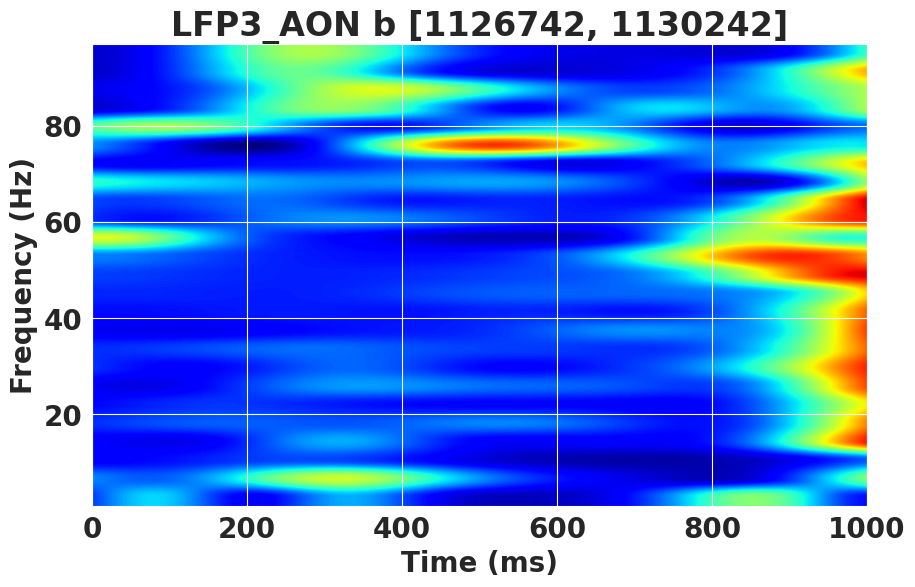

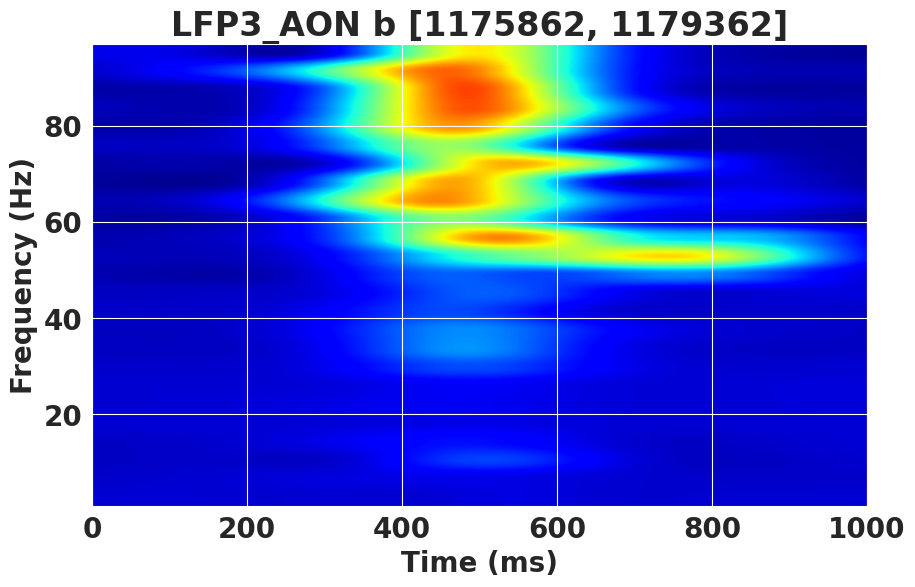

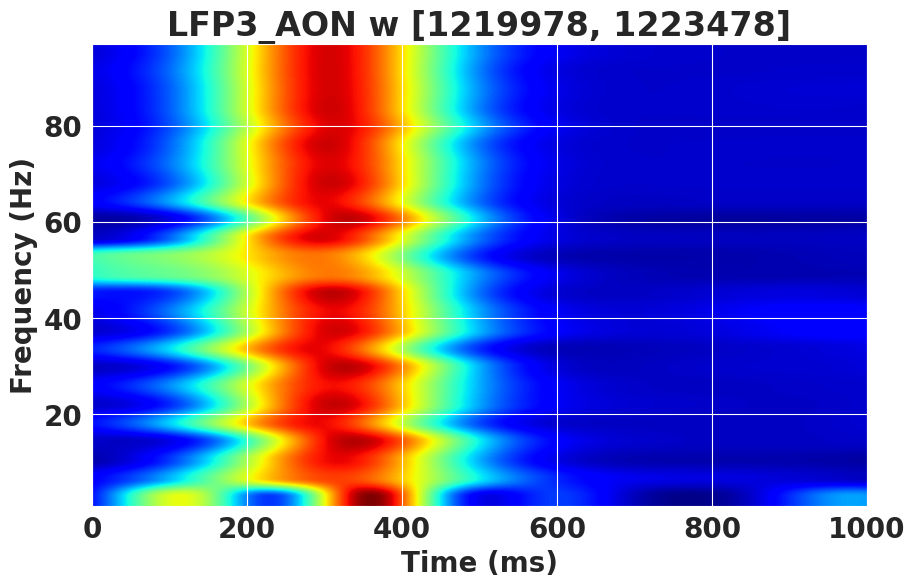

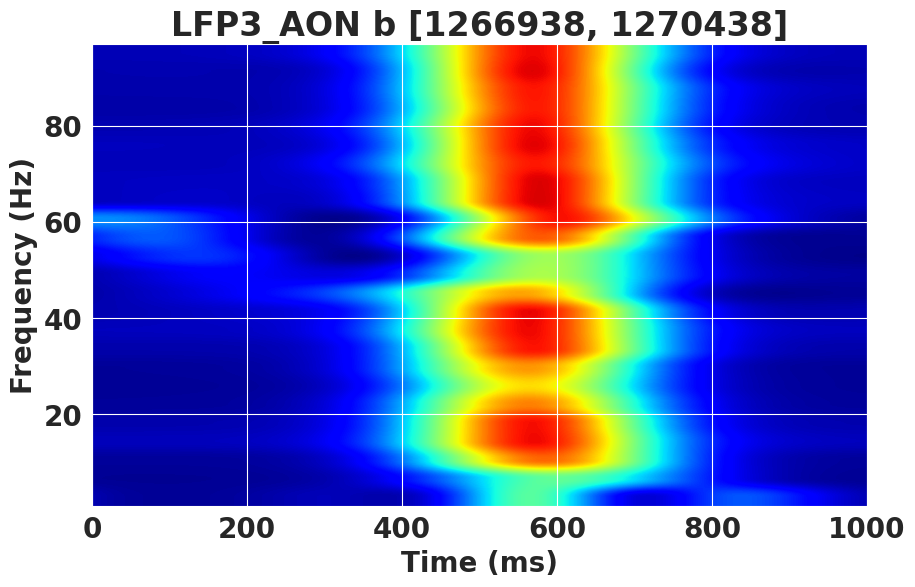

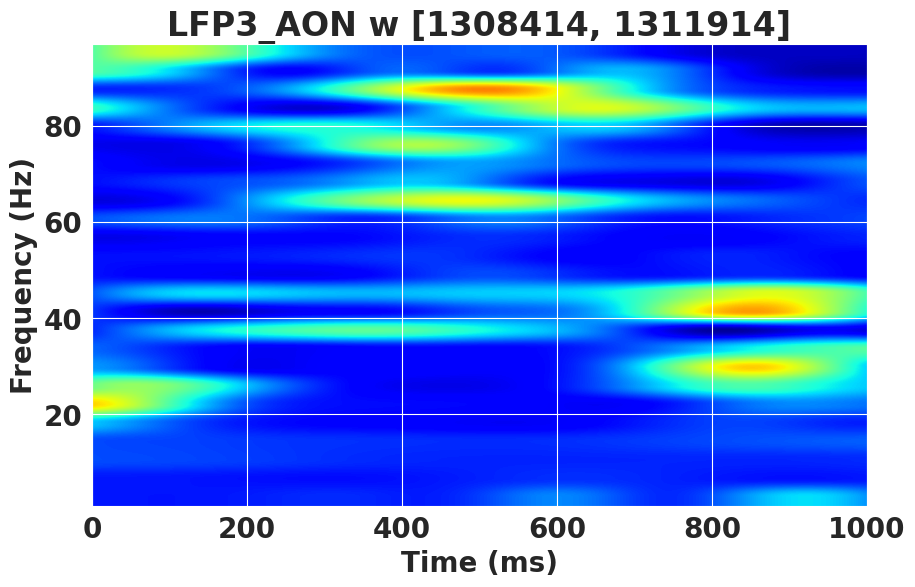

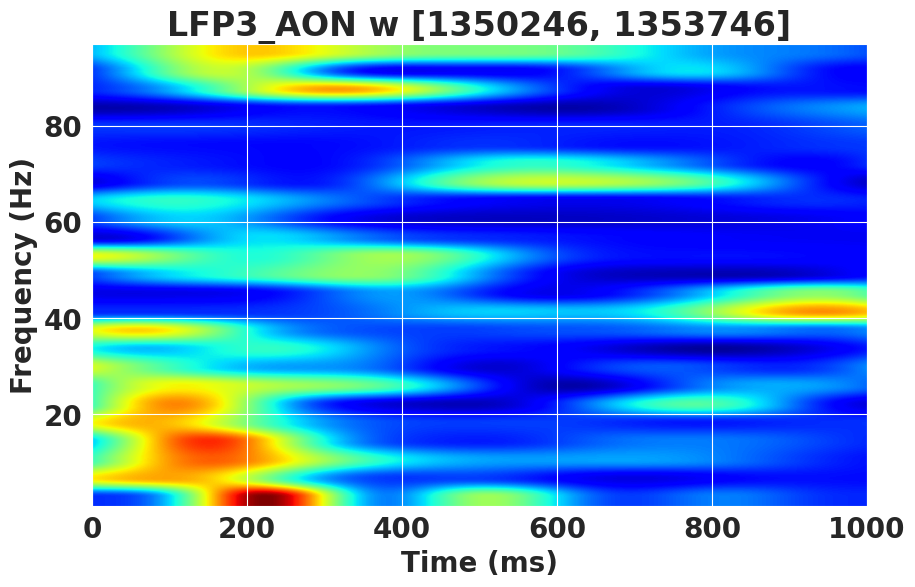

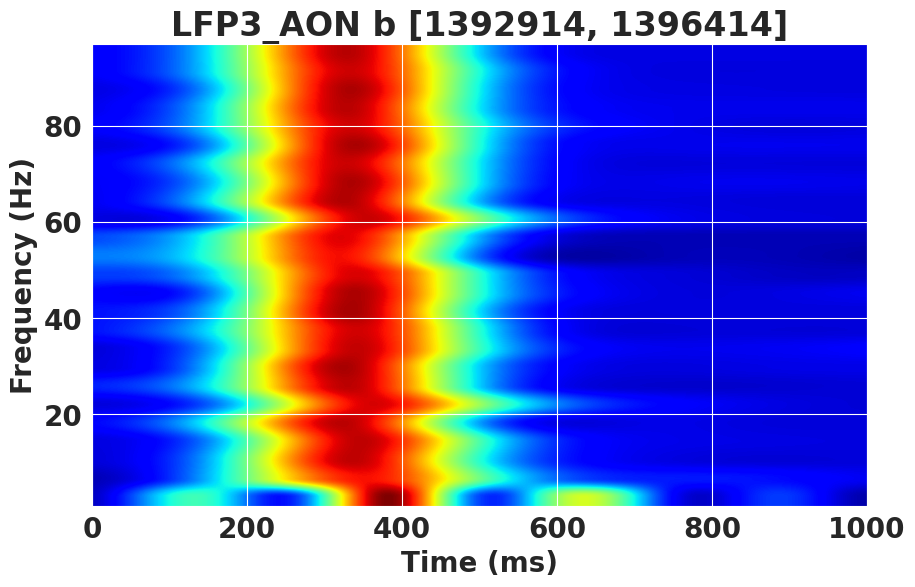

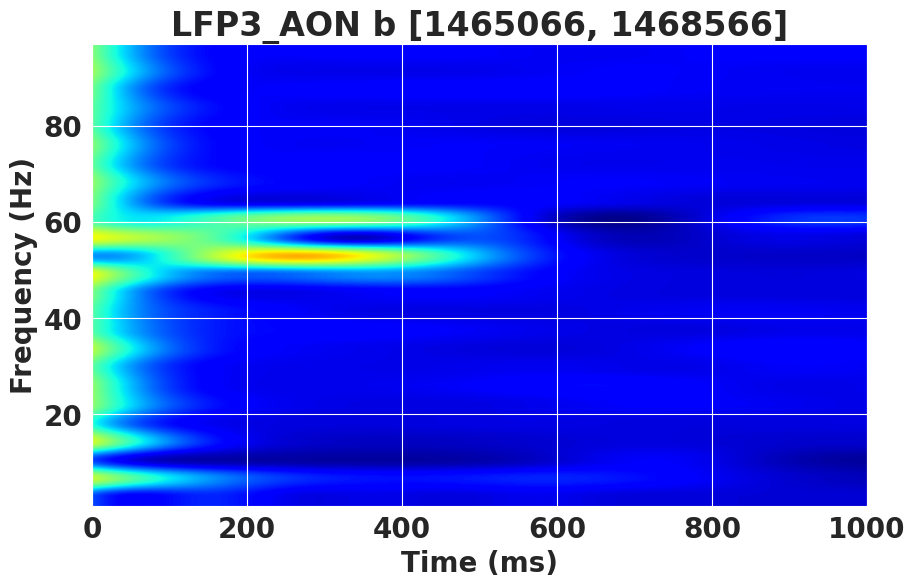

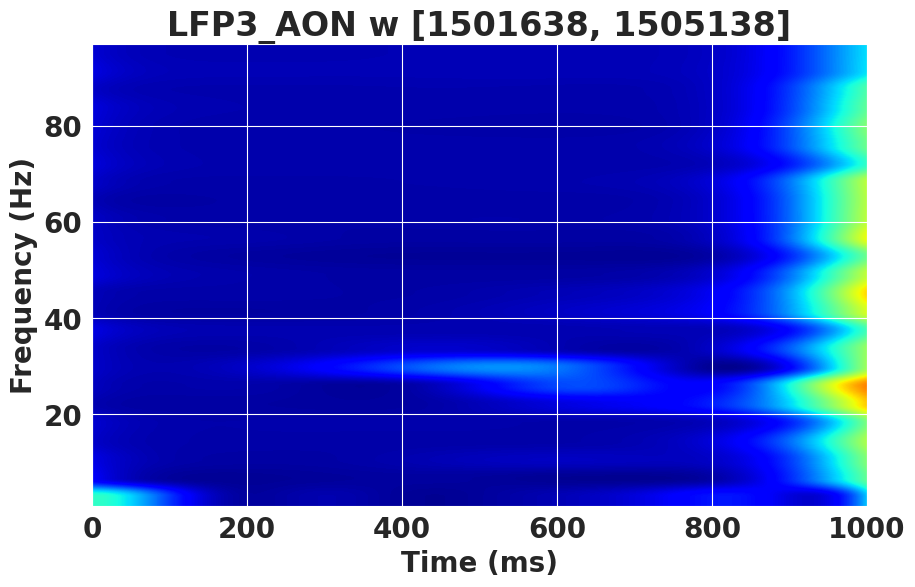

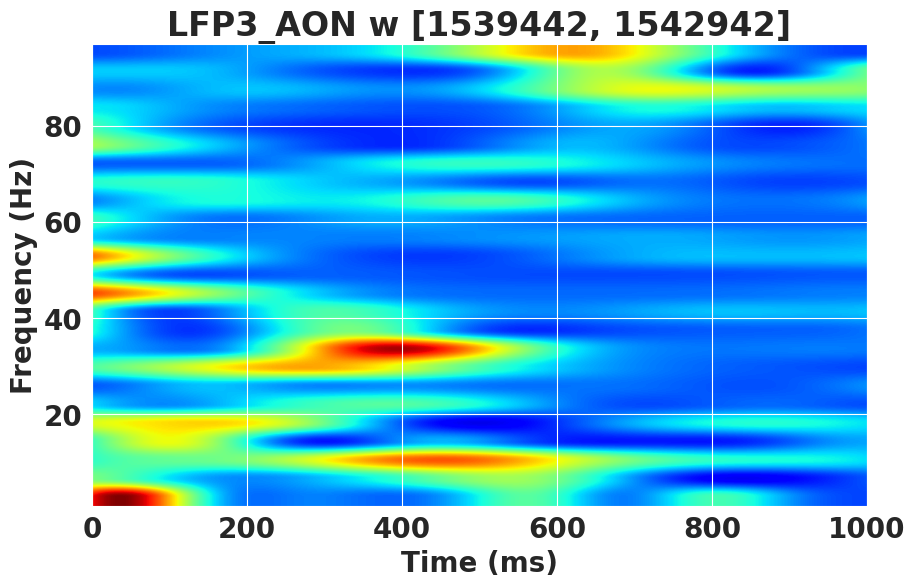

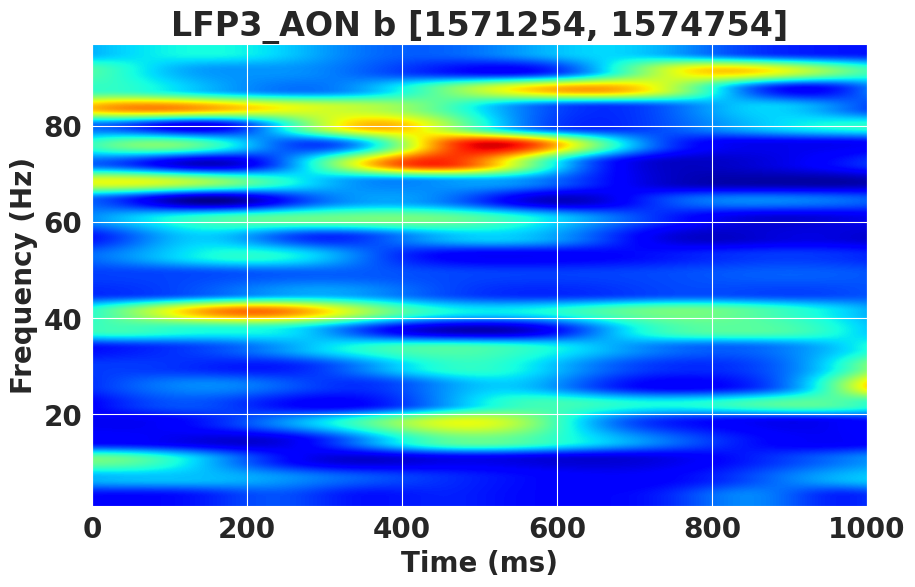

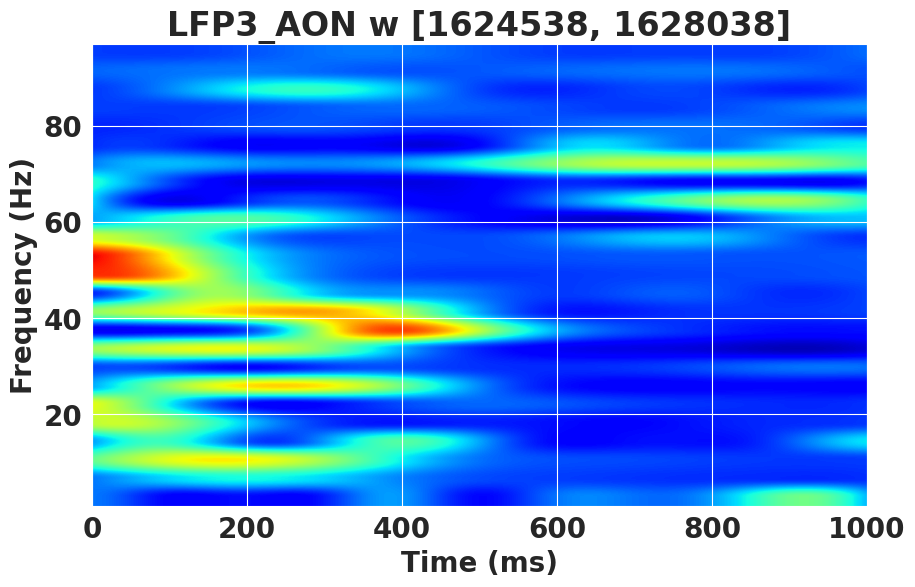

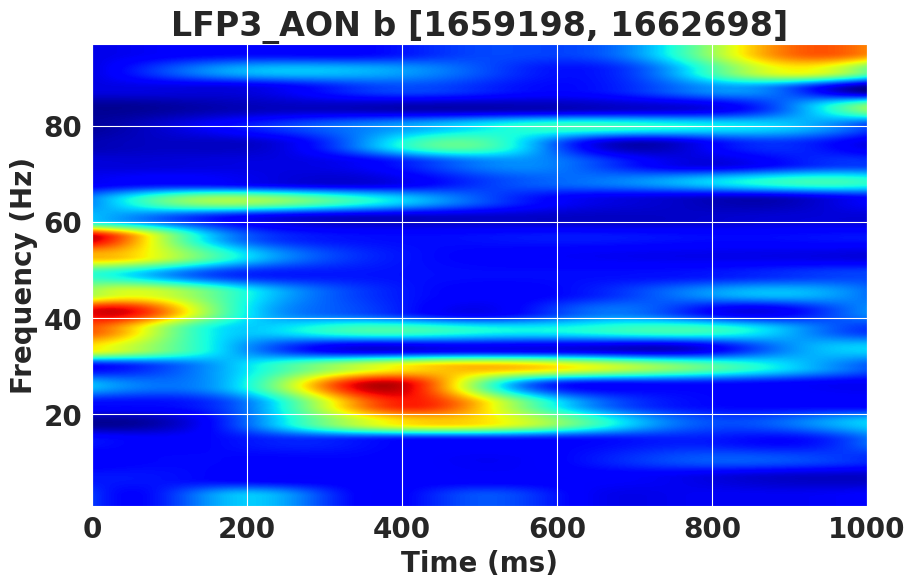

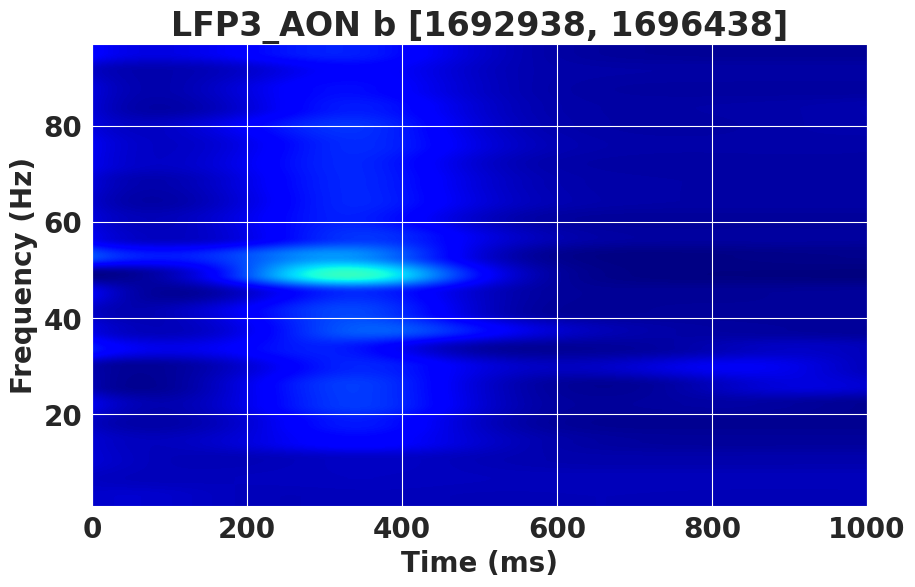

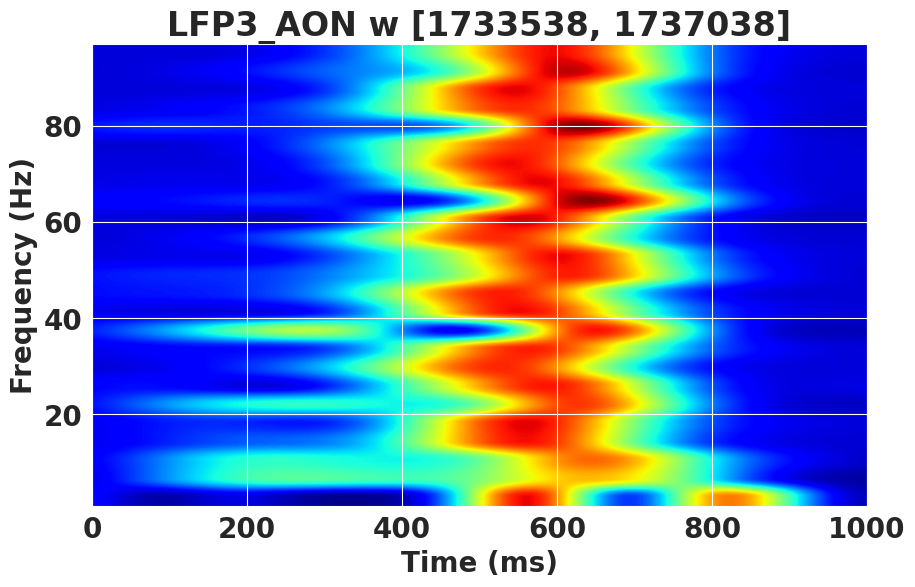

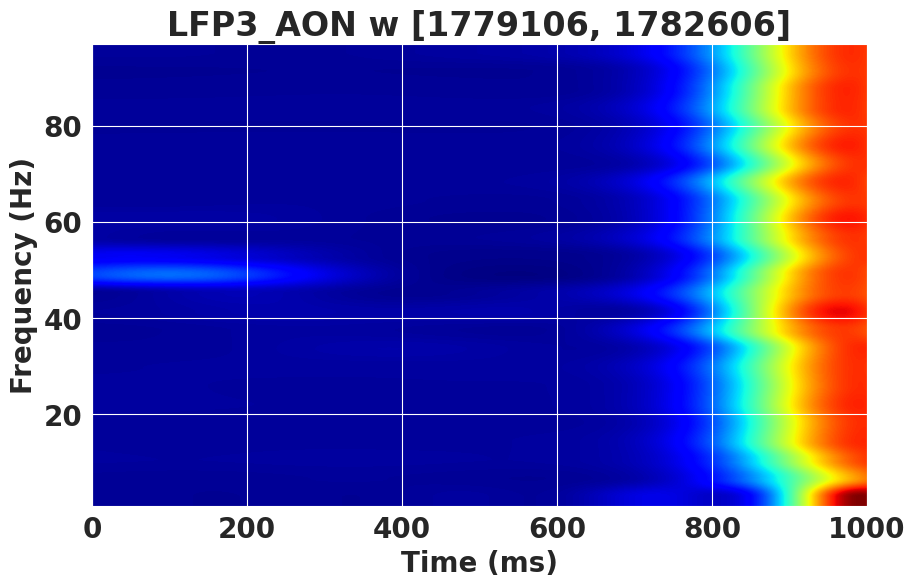

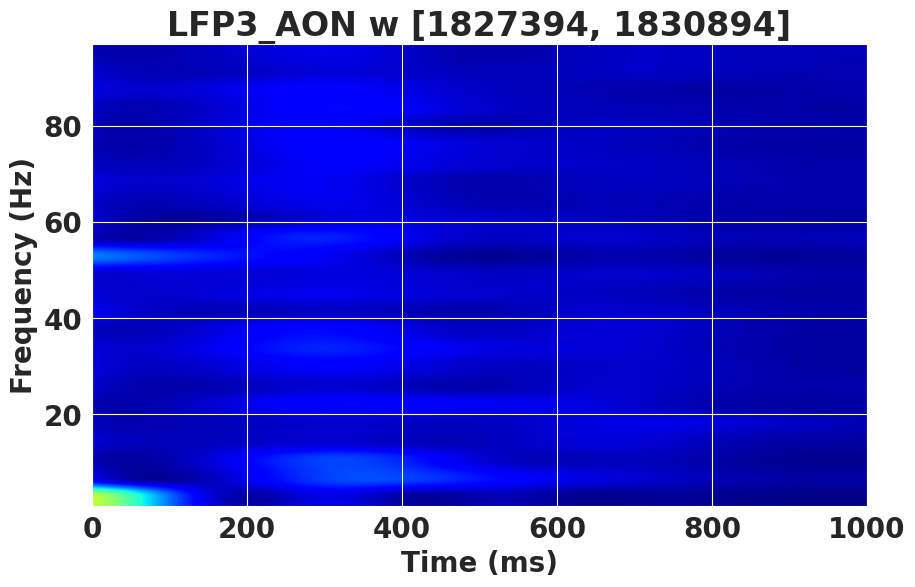

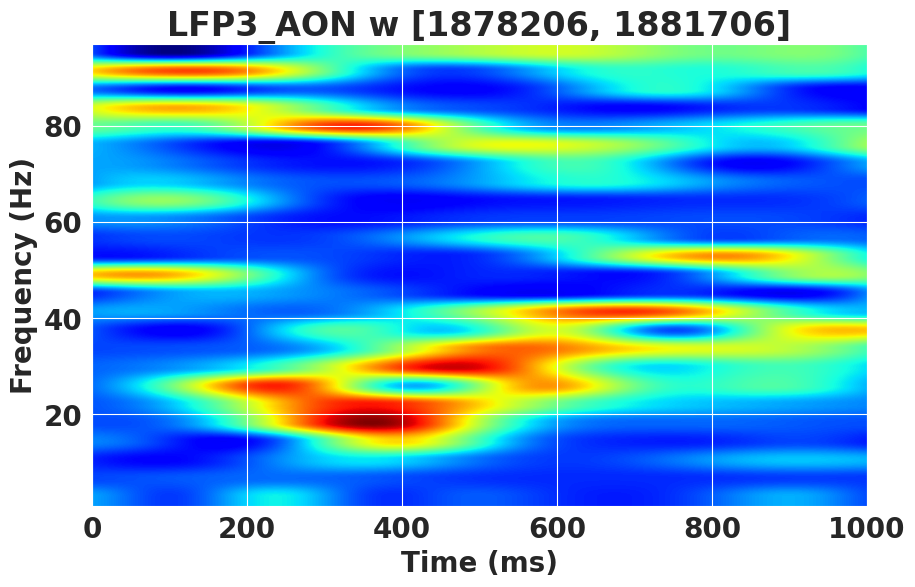

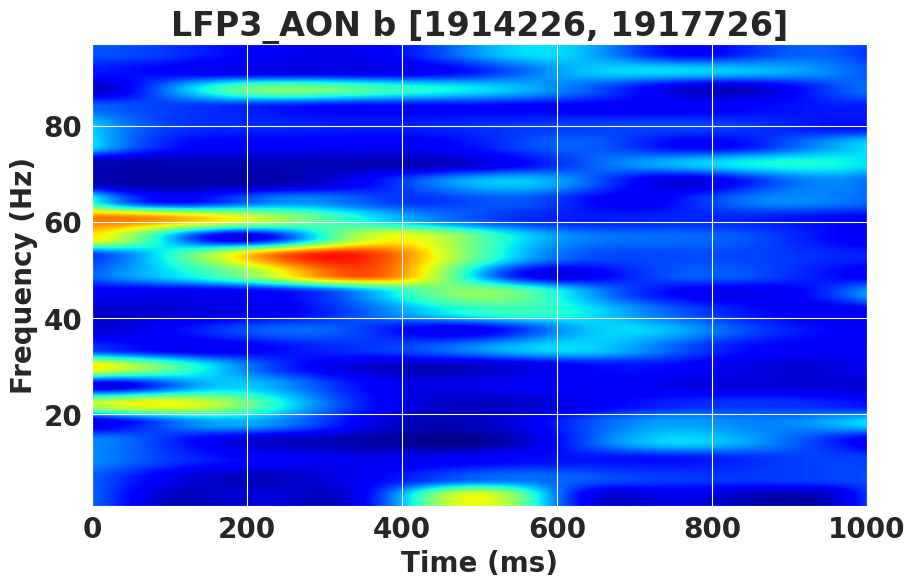

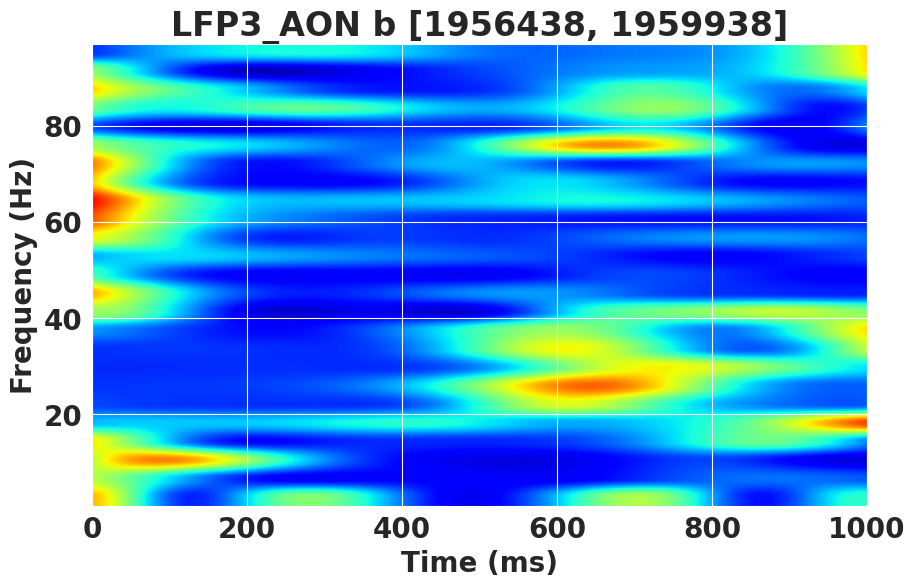

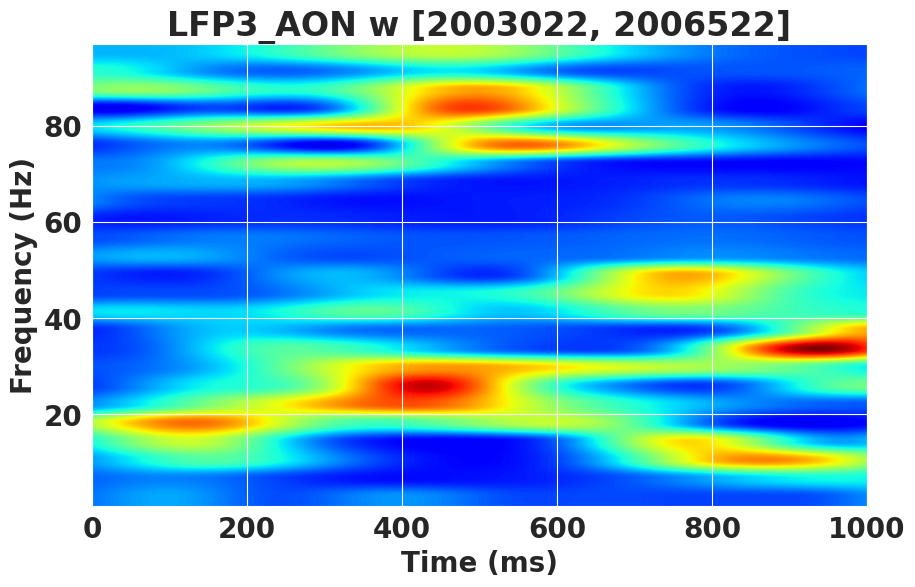

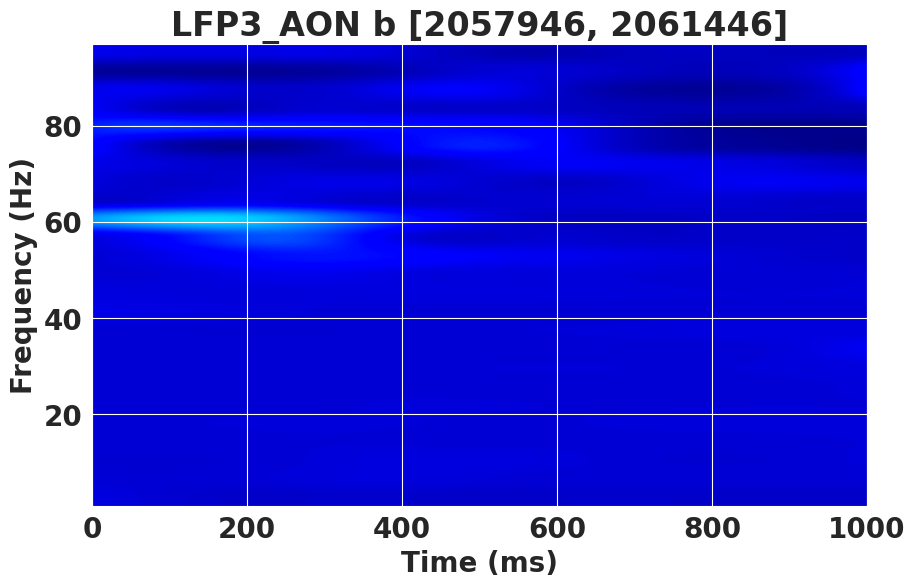

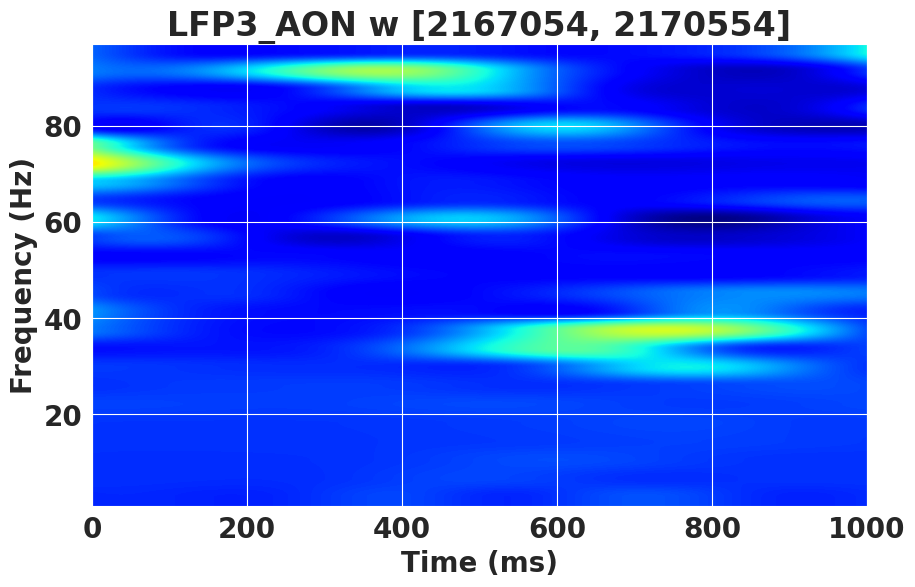

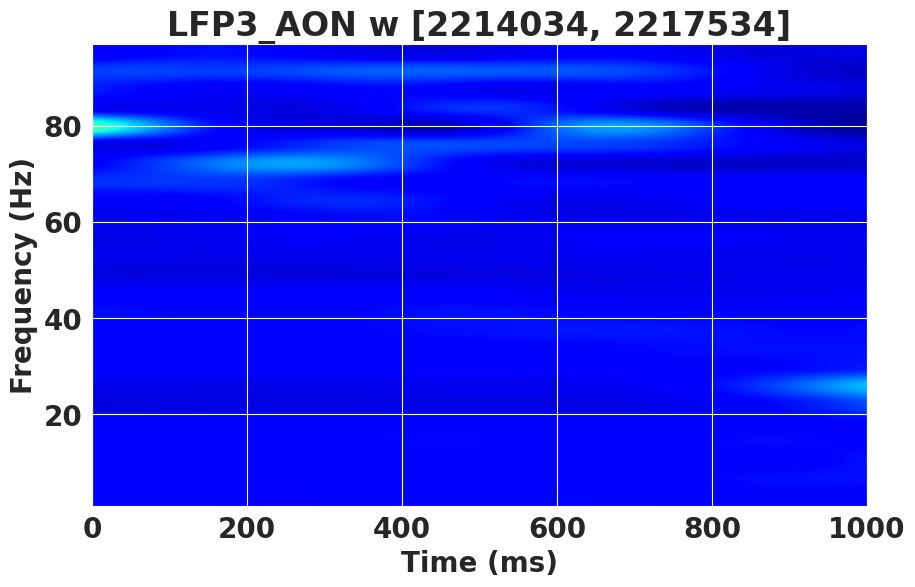

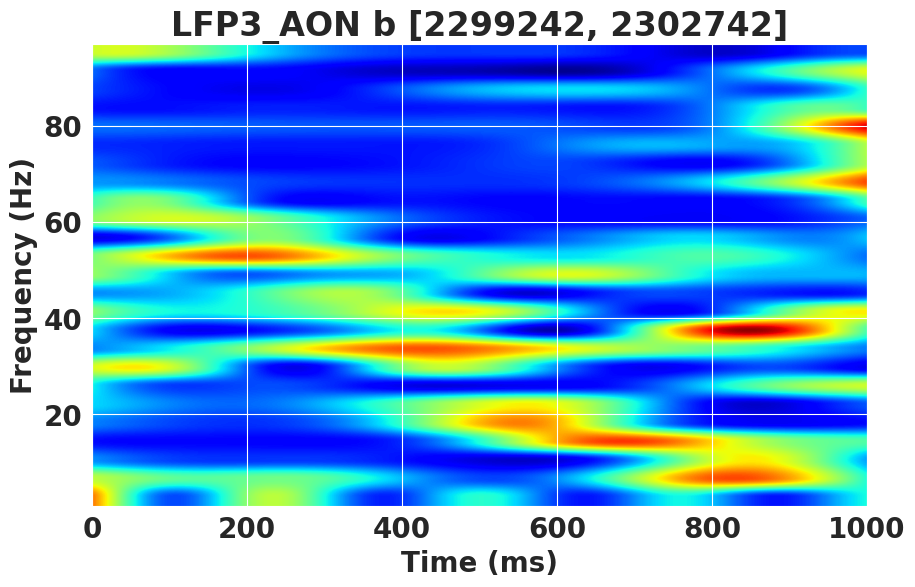

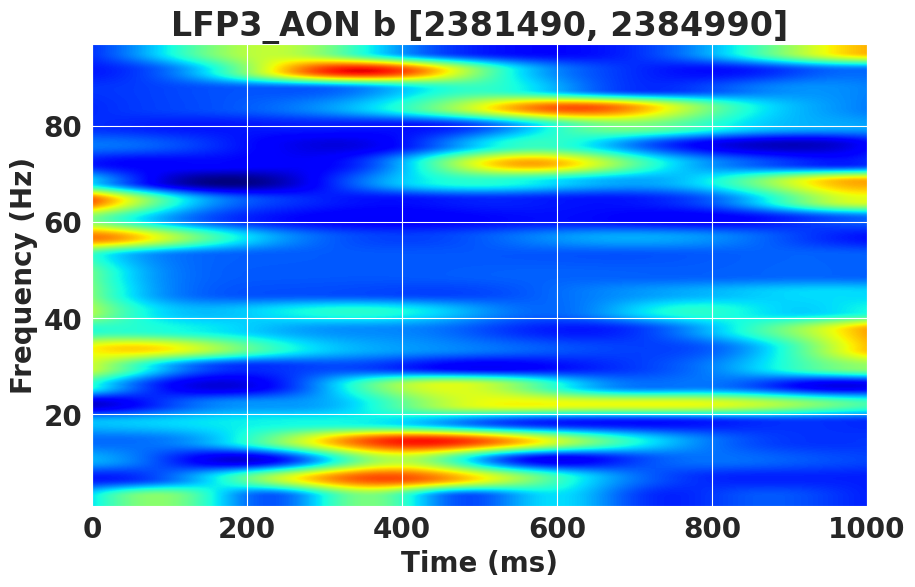

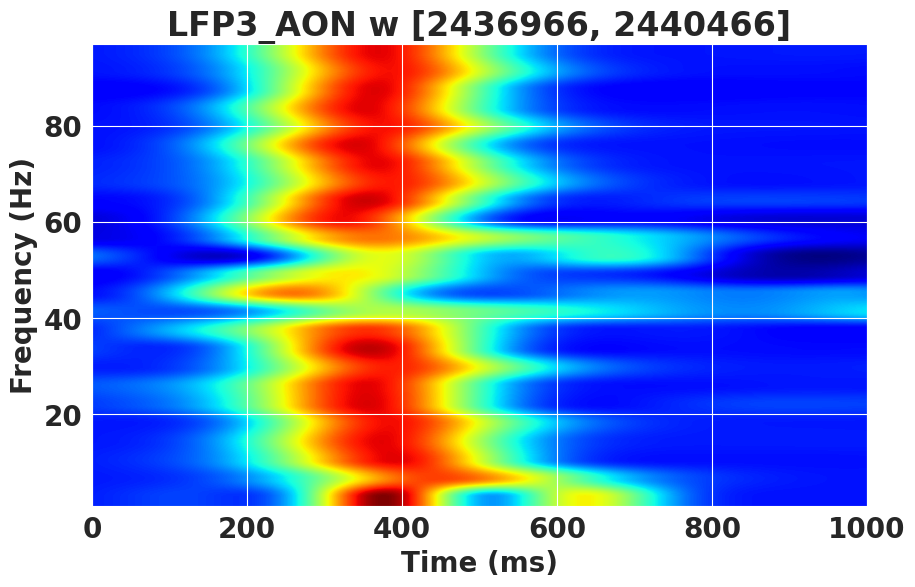

In [8]:
plt.rcParams.update({'font.size': 20, 'font.weight': 'bold', 'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})
 
channel = "LFP3_AON"
evt = lfp.event_times[0]
event = lfp.events[0]
relative_times = [-2000,1500]
for event, evt in zip(lfp.events, lfp.event_times):
    if event in ["0", "1", "00", "01", "10", "11"]:
        continue
    time_segment = [int(evt*fs)+relative_times[0], int(evt*fs)+relative_times[1]] 

    info = mne.create_info(ch_names=list(map(str, np.arange(1, 2, 1))), sfreq=fs, ch_types=['eeg'])
    epoch = np.empty((1, 1, len(np.arange(time_segment[0], time_segment[1],1))))
    epoch[0,0,:] = lfp.spikes[channel][time_segment[0]:time_segment[1]] #Format data into [epochs, channels, samples] format
    epoch = mne.EpochsArray(epoch, info, verbose=False)
    freqs = np.arange(1,100,4)
    n_cycles = freqs / 2
    tf_pow = mne.time_frequency.tfr_morlet(epoch, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=False, verbose=False)
    baseline_max = tf_pow.times[-1]  # Last time point in epochs data
    tf_pow.apply_baseline(mode='zscore', baseline=(0, baseline_max))
    tf_pow.data = np.squeeze(tf_pow.data)
    plt.figure(figsize=(10,6))
    plt.title(f"{channel} {event} {time_segment}")
    plt.imshow(tf_pow.data, extent=[relative_times[0], relative_times[1], tf_pow.freqs[0], tf_pow.freqs[-1]],
               aspect = 'auto', origin = 'lower', cmap='jet')
    plt.xlim([0, 1000])
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')

In [ ]:
for idx, (ev_type, windows) in enumerate(window_dict.items()):
    if len(windows) == 0:
        continue
    
    # Create a new figure for each event type
    fig, axes = plt.subplots(1, len(windows), figsize=(20, 5), sharex=True, sharey=True)
    
    # Make sure axes is a list even if there's only one subplot
    if len(windows) == 1:
        axes = [axes]
    
    for window_idx, window in enumerate(windows):
        
        ax = axes[window_idx]
        window_indices = [int(x * fs) for x in window]
        title = f"{ev_type} {window}"
        ax.set_title(title)
        
        for channel in lfp.spikes.columns:
            
            # Assuming lfp_data is the dataframe containing your LFP data
            segment = lfp.spikes.loc[window_indices[0]:window_indices[1], channel]
            frequencies, psd_values = welch(segment, fs=fs)
            
            # Exclude 0 Hz
            frequencies, psd_values = frequencies[1:], psd_values[1:]
            
            # Generate a unique string using the channel name and window
            random_string = f"{channel}_{window}"
            
            # Initialize and fit FOOOF model
            freq_res = frequencies[1] - frequencies[0]
            peak_width_limits = [2 * freq_res, 16]
            
            fm = FOOOF(peak_width_limits=peak_width_limits)
            fm.fit(frequencies, psd_values)
            
            # Plot the FOOOF model on the existing Axes object
            fm.plot(ax=ax)

    plt.tight_layout()
    plt.show()